In [1]:
# drop in the 3d example plot

In [2]:
import xarray as xr
import pandas as pd
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import datetime
import glob
# import my_library
import matplotlib as mpl
import numpy as np
import string
import dask
dask.config.set(**{'array.slicing.split_large_chunks': True})
from matplotlib.colors import ListedColormap
import matplotlib.image as mpimg
import global3d_track as g3d
my_tools = g3d.scripts.src.utils.analysis_tools
src = g3d.scripts.src
import pathlib

In [3]:
savedir = pathlib.Path('../figures')

In [4]:
# load data

In [5]:
# grab system mask

data_dir = '/work/bb1153/b382635/data/final_tracks/updraft_ice_only/amazon'
s = 12734
mask = src.utils.data_tools.grab_system(s, data_dir)
mask = mask.where(mask>0)

# get data

variables = ['cli', 'clw', 'wa_phy','pfull', 'zg']
data = src.utils.data_tools.load_corresponding_data(mask, None, variables=variables)
data = src.utils.data_tools.preprocess_for_tobac(data)
data['lat'] = data.lat.round(2)
data['lon'] = data.lon.round(2)
mask['lat'] = mask.lat.round(2)
mask['lon'] = mask.lon.round(2)

data['condensate'] = data.cli + data.clw

INFO:root:masking to system 12734
INFO:root:Region to regrid: (-75.8, -72.5, 9.1, 12.7)


In [6]:
# plot

In [7]:
def plot_surface(ax, ds, z, params={}):
    img = mpimg.imread("/work/bb1153/b382635/data/world.200407.3x5400x2700.jpg")
    lat = ds.lat.values[::-1]
    lon = ds.lon.values
    X, Y = np.meshgrid(lon, lat)
    z_surface = np.full_like(X, z)

    img_lat_res = 180 / img.shape[0]
    img_lon_res = 360 / img.shape[1]

    lat_start = int((90 - lat.max()) / img_lat_res)
    lat_end = int((90 - lat.min()) / img_lat_res)
    lon_start = int((lon.min() + 180) / img_lon_res)
    lon_end = int((lon.max() + 180) / img_lon_res)

    img_cropped = img[lat_start:lat_end, lon_start:lon_end]
    img_cropped = np.clip(img_cropped / 255 * 1.2, 0, 1)

    img_rgb = img_cropped[..., :3] if img_cropped.ndim == 3 else np.stack([img_cropped]*3, axis=-1)

    surface_params = dict(rstride=1, cstride=1, alpha=0.5, edgecolor='none', linewidth=0, shade=False)
    surface_params.update(params)
    ax.plot_surface(X, Y, z_surface, facecolors=img_rgb, zorder=0, **surface_params)
    return ax

def plot_scatter(ax, ds, hue, params={}, cmap='Blues', z='level_full'):
    scatter_params = dict(add_colorbar=False, zorder=3)
    scatter_params.update(params)
    cmap_vals = plt.get_cmap(cmap)(np.linspace(0.5, 1.0, 256))
    cmap_vals[:, -1] = np.linspace(0, 1, 256)
    cmap = ListedColormap(cmap_vals)
    ds.plot.scatter(ax=ax, x='lon', y='lat', z=z, hue=hue, edgecolors='none', cmap=cmap, **scatter_params)
    return ax

def modify_axis(ax, d, fsize=12, label_axes=True, z='level_full'):
    ax.set_xlim(d.lon.min(), d.lon.max())
    ax.set_ylim(d.lat.min(), d.lat.max())
    ax.set_zlim(d[z].min(), d[z].max())
    ax.grid(True)
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    if label_axes:
        ax.set_xlabel("Longitude [°]", fontsize=fsize)
        ax.set_ylabel("Latitude [°]", fontsize=fsize)
    else:
        ax.set_xlabel("")
        ax.set_ylabel("")
    ax.set_zlabel("")
    ax.tick_params(labelsize=fsize)
    ax.set_zticklabels([])
    ax.set_title('')
    return ax

In [8]:
# get heights
z_pfull = data.pfull.mean(('lat','lon','time'))
z_zg = data.zg.mean(('lat','lon')) / 1000

In [9]:
# Data preprocessing
dc = data.where(data > 1e-5).where(mask.system > 0)
dw = data.where(np.abs(data) > 0.25)  # Not used in current plot, consider removing if unnecessary
dc = dc.assign_coords({'zg':z_zg})
dw = dw.assign_coords({'zg':z_zg})
dc = dc.compute()
dw = dw.compute()

mask = mask.assign_coords({'zg':z_zg})

In [10]:
def make_proj(ax, data, coord='level_full', levels=[0.5], params=dict(offset=-1, cmap='viridis')):
    if coord=='level_full':
        m = data.sel(time=t).max('level_full')
        X, Y = np.meshgrid(m.lon, m.lat)
        ax.contour(X, Y, (m.fillna(0)).astype(int), levels, zdir='z', **params)
    if coord=='lon':
        m = data.sel(time=t).max('lon')
        Y, Z = np.meshgrid(m.lat, m.zg)
        ax.contour((m.fillna(0)).astype(int), Y, Z, levels, zdir='x', **params)
    if coord=='lat':
        m = data.sel(time=t).max('lat')
        X, Z = np.meshgrid(m.lon, m.zg)
        ax.contour(X, (m.fillna(0)).astype(int), Z, levels, zdir='y', **params)
    return ax

In [11]:
unique_cores = np.unique(mask.u_tracks.values)
unique_cores = unique_cores[~np.isnan(unique_cores)]

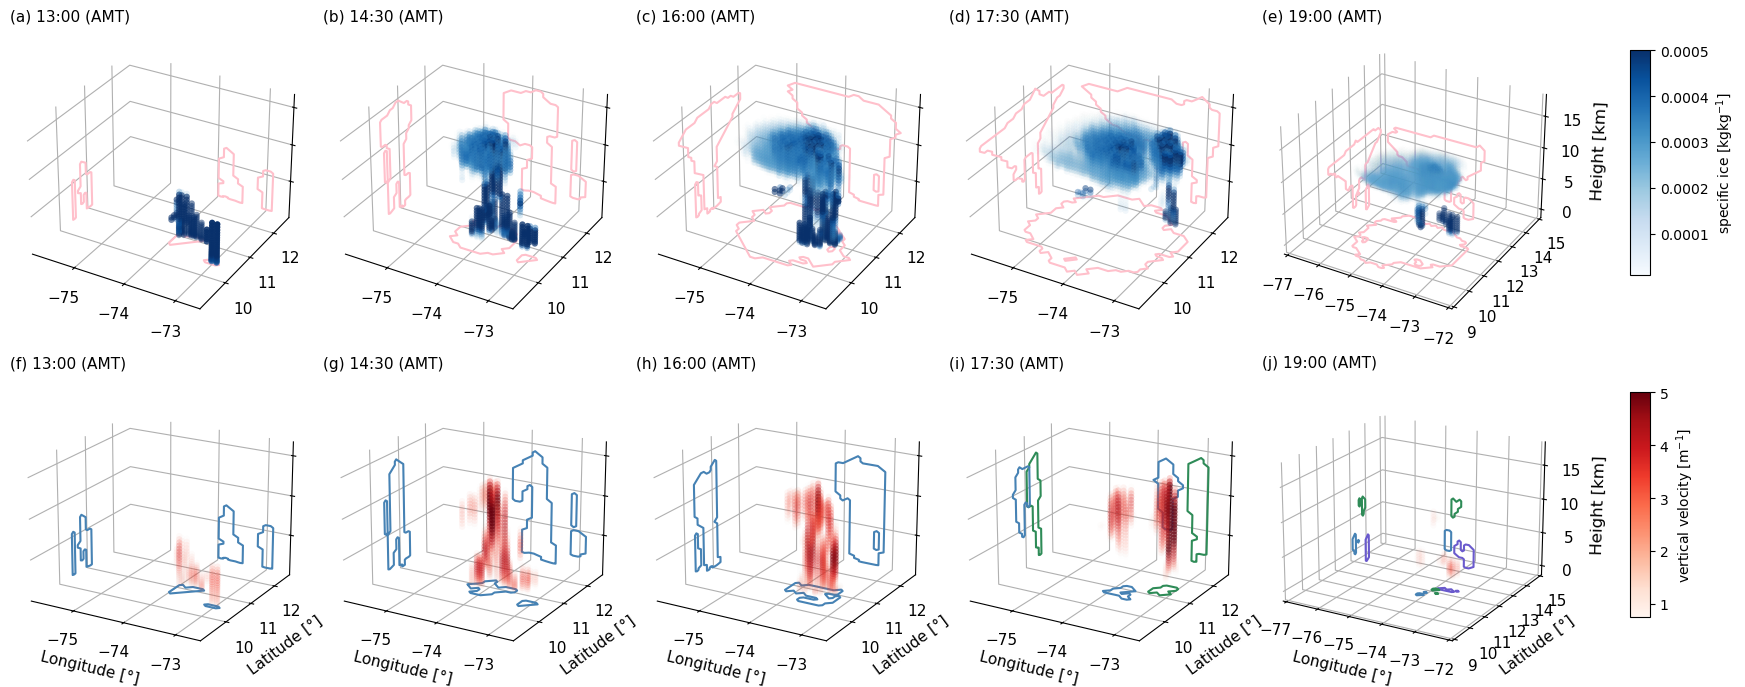

In [13]:
# Choose times
times = mask.time.values[7::6]

# title prep
letters = list(string.ascii_lowercase)
title_params = dict(fontsize=11, loc='left')

# fig
ncols = 5
fig, axes = plt.subplots(2,ncols, figsize=(20, 9), subplot_kw=dict(projection='3d'))

for i, tidx in enumerate(times):
    if i >= ncols:
        break
    # collect
    axs = axes[:, i]
    t = pd.to_datetime(tidx)
    t_amt = t - datetime.timedelta(hours=4)
    d = dc.sel(time=t)
    
    # Condensate plot
    ax = axs[0]
    norm = plt.Normalize(vmin=1e-5, vmax=5e-4)
    isc = plot_scatter(ax, d, hue='condensate', params=dict(s=20, norm=norm), cmap='Blues', z='zg')
    ax.view_init(elev=30, )
    ax = modify_axis(ax, d, fsize=11, label_axes=False, z='zg')
    ax.set_title(f"({letters[i]}) {t_amt.strftime('%H:%M (AMT)')}", **title_params)

    # add mask contours
    colors = 'pink'
    ax = make_proj(ax, mask.system>0, coord='level_full', params=dict(offset=mask.zg.min().item(), colors=colors))
    ax = make_proj(ax, mask.system>0, coord='lon', params=dict(offset=mask.lon.min().item(), colors=colors))
    ax = make_proj(ax, mask.system>0, coord='lat', params=dict(offset=mask.lat.max().item(), colors=colors))

    # Vertical velocity plot
    ax = axs[1]
    norm = plt.Normalize(vmin=0.75, vmax=5)
    usc = plot_scatter(ax, d, hue='wa_phy', params=dict(s=20, norm=norm), cmap='Reds', z='zg')
    ax.view_init(elev=20, )
    ax = modify_axis(ax, d, fsize=11, label_axes=True, z='zg')
    ax.set_title(f"({letters[i+ncols]}) {t_amt.strftime('%H:%M (AMT)')}", **title_params)

    # add mask contours
    colors = ('steelblue','seagreen','slateblue','turquoise')
    for j,c in enumerate(unique_cores):
        col = colors[j]
        ax = make_proj(ax, mask.u_tracks==c, coord='level_full', params=dict(offset=mask.zg.min().item(), colors=col))
        ax = make_proj(ax, mask.u_tracks==c, coord='lon', params=dict(offset=mask.lon.min().item(), colors=col))
        ax = make_proj(ax, mask.u_tracks==c, coord='lat', params=dict(offset=mask.lat.max().item(), colors=col))

# z-label and ticks on the last column only
for ax in axes[:, -1]:
    ax.set_zticks([0,5,10,15])
    ax.set_zticklabels([0,5,10,15])
    ax.set_zlabel("Height [km]", fontsize=12)

# limits
for ax in axs.flat:
    ax.set_xlim(-77,-72)
    ax.set_ylim(9,15)
    ax.set_zlim(-1,18)

# add colorbars
w, h = 0.01, 0.25
i_cmap = mpl.cm.ScalarMappable(norm=plt.Normalize(vmin=1e-5, vmax=5e-4), cmap='Blues')
w_cmap = mpl.cm.ScalarMappable(norm=plt.Normalize(vmin=0.75, vmax=5), cmap='Reds')
fig.colorbar(i_cmap, cax=fig.add_axes([.935, 0.58, w, h]), label='specific ice [kgkg$^{-1}$]')
fig.colorbar(w_cmap, cax=fig.add_axes([.935, 0.2, w, h]), label='vertical velocity [m$^{-1}$]')

# save
fig.tight_layout(rect=[0.01, 0.01, 0.99, 0.98])
fig.subplots_adjust(hspace=0, wspace=0.05)
fig.savefig(savedir / f"figure_06.pdf", dpi=300, bbox_inches='tight', pad_inches=0.1)
